<a href="https://colab.research.google.com/github/lukazeljkovic/ERP-NajlONline/blob/main/PPPO_IT16_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detekcija godina i pola

**Student**: Luka Zeljković <br>
**Predmet**: Principi prezentacije i prepoznavanje oblika <br>
**Tema projektnog zadatka**: Detekcija godina, pola i emocija <br>


***


Tokom poslednje decenije, oblast obrade slika doživela je ogroman rast, i to zahvaljujući velikom tehnološkom napretku hardvera. Kompjuterska vizija (Computer Vision - CV) primenjuje se na različite načine, poput video nadzora, prepoznavanja objekata, prepoznavanja slika, ili klasifikacije i druge aktivnosti koje uključuju interakciju između čoveka i računara 

Ekstrakcija korisnih biometrijskih odlika poput godina, pola i emocija je u današnje vreme veoma važan zadatak u oblasti procesiranja slika. Svako ljudsko lice je jedinstveno na svoj način i sadrži vitalne odlike koje mogu da otkriju broj godina, pol, rasu i facijalne ekspresije.

Za samu izradu projekta, biće korišćeni predefinisani modeli upotrebom Transfer Learning-a, odnosno tehnike gde se pre-trained modeli prilagođavaju zadatku zamenom poslednjeg layer-a, kako bi odgovarao broju kategorija koje su moguće za dati dataset. Kao modeli, na osnovu prethodno pokazanih dobrih iskustava za rešavanje sličnih problema klasifikacije, izabrani su CNN (Convolutional Neural Network) modeli VGG16 i ResNet50

***

Na samom početku projekta izvršeno je pretprocesiranje kompletnog dataset-a iz nekoliko razloga:

1. NEKE SLIKE SU OŠTEĆENE
2. SLIKE SU RAZLIČITIH VELIČINA 
3. NA POJEDINIM SLIKAMA NEMA LICA 
4. PODACI NISU PRAVILNO BALANSIRANI (više ima muških nego ženskih lica)
5. META PODACI SU U .MAT FORMATU, A TREBALI BI DA BUDU U .CSV

***

U projektu je izvršena filtracija podataka tako da su oni smešteni u odgovarajućem formatu. Nakon toga je izvršena konverzija .mat fajla u .csv format. Kada je fajl uspešno kreiran, na osnovu njega je izvršeno kreiranje modela, koji je treniran i testiran pomoću odgovarajućih algoritama. 
Među podacima nije postojala informacija o emocijama, te je u te svrhe korišćena druga metodologija kako bi se ispunio i taj trećinski deo projekta.

# Učitavanje i pregled podataka

Na početku instaliram i importujem sve potrebne biblioteke za ovaj projekat

In [1]:
from google.colab import drive
import numpy as np
import matplotlib.pylab as plt
import os
import pandas as pd
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from skimage.io import imread
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
from PIL import Image
import cv2
!pip install mtcnn
import mtcnn
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
!pip install fast_ml
from fast_ml.model_development import train_valid_test_split
import numpy as np #podrška za višedimenzionalne nizove i matrice, kao i za matemetičke funkcije
from scipy.io import loadmat #podrška kako bih učitala matlab fajl
import pandas as pd #podrška za reprezentaciju i manipulaciju podacima
import datetime as date #podrška za rad sa datumima
from dateutil.relativedelta import relativedelta #podrška za računanje razlike dva datuma
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scipy.io import loadmat
from tensorflow.keras.applications.vgg16 import VGG16
#https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/
# googleimagesdownload --keywords "Euler" --limit 20
%matplotlib inline
#from keras.models import load_model
from tensorflow.keras.models import load_model
#!pip install mtcnn
import mtcnn
# print version
print(mtcnn.__version__)
from mtcnn.mtcnn import MTCNN
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from skimage.io import imread
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
import numpy as np
import matplotlib.pylab as plt
import os
!pip install dlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 26.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 890 kB/s 


Prvo je potrebno učitati dataset koji je dobijen u sklopu projektnog zadatka

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ztlCf2S68-k4ulB05gWsxGZtbU98jIx_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ztlCf2S68-k4ulB05gWsxGZtbU98jIx_" -O images.zip && rm -rf /tmp/cookies.txt

--2022-08-25 07:40:07--  https://docs.google.com/uc?export=download&confirm=t&id=1ztlCf2S68-k4ulB05gWsxGZtbU98jIx_
Resolving docs.google.com (docs.google.com)... 172.253.62.101, 172.253.62.139, 172.253.62.138, ...
Connecting to docs.google.com (docs.google.com)|172.253.62.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/759rekl80nctv4akm92d33at10ps1me8/1661413200000/06049624160957438625/*/1ztlCf2S68-k4ulB05gWsxGZtbU98jIx_?e=download&uuid=5ea5e6ca-b868-4745-b17a-b9ad9baefbaf [following]
--2022-08-25 07:40:07--  https://doc-14-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/759rekl80nctv4akm92d33at10ps1me8/1661413200000/06049624160957438625/*/1ztlCf2S68-k4ulB05gWsxGZtbU98jIx_?e=download&uuid=5ea5e6ca-b868-4745-b17a-b9ad9baefbaf
Resolving doc-14-64-docs.googleusercontent.com (doc-14-64-docs.googleusercontent.com)... 142.251.33.193, 

Zatim sam otpakovao učitani dataset

In [3]:
!unzip images.zip

Streaming output truncated to the last 5000 lines.
  inflating: wiki_crop/91/7259691_1983-04-27_2012.jpg  
  inflating: wiki_crop/91/7287691_1979-08-29_2012.jpg  
  inflating: wiki_crop/91/7294591_1987-12-25_2011.jpg  
  inflating: wiki_crop/91/731591_1964-07-17_2008.jpg  
  inflating: wiki_crop/91/739691_1956-09-20_2011.jpg  
  inflating: wiki_crop/91/741791_1917-12-18_2004.jpg  
  inflating: wiki_crop/91/743391_1954-03-15_2015.jpg  
  inflating: wiki_crop/91/7464891_1984-09-30_2013.jpg  
  inflating: wiki_crop/91/7534191_1983-04-17_2010.jpg  
  inflating: wiki_crop/91/763791_1934-12-30_1990.jpg  
  inflating: wiki_crop/91/7671891_1987-03-02_2006.jpg  
  inflating: wiki_crop/91/7711491_1982-12-06_2014.jpg  
  inflating: wiki_crop/91/77491_1916-04-05_1948.jpg  
  inflating: wiki_crop/91/779591_1953-03-01_2014.jpg  
  inflating: wiki_crop/91/7798491_1947-01-25_2013.jpg  
 extracting: wiki_crop/91/783791_1917-06-18_1967.jpg  
  inflating: wiki_crop/91/794891_1970-02-12_2011.jpg  
  infla

Sledeća ćelija prikazuje učitavanje .mat fajla sa meta podacima.

In [4]:


loadmat('/content/wiki_crop/wiki.mat')

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jan 16 16:25:20 2016',
 '__version__': '1.0',
 '__globals__': [],
 'wiki': array([[(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
                 array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
                 array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
                 array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
                 array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
                 array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
               dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
                 array(['Dettmar Cramer'], dtype='<U14'),
                 array(['Marc Okrand'], dtype='<U11'), ...,
                 arr

Nakon što je fajl uspešno učitan sledi njegova konverzija u csv format.

Odlučio sam da godine predstavim u intervalima od 10 godina.

In [5]:


#Kolone u .csv fajlu
cols = ['age', 'gender', 'path']

wiki_mat = '/content/wiki_crop/wiki.mat'

#Učitaj .mat fajl
wiki_data = loadmat(wiki_mat)

del wiki_mat

wiki = wiki_data['wiki']

wiki_photo_taken = wiki[0][0][1][0]
wiki_full_path = wiki[0][0][2][0]
wiki_gender = wiki[0][0][3][0]

wiki_path = []

for path in wiki_full_path:
    wiki_path.append('wiki_crop/' + path[0])

wiki_genders = []

for n in range(len(wiki_gender)):
    if wiki_gender[n] == 1:
        wiki_genders.append(1)
    else:
        wiki_genders.append(0)

wiki_dob = []

for file in wiki_path:
    wiki_dob.append(file.split('_')[2])

wiki_age = []

#Računa razliku u godinama između datuma rođenja osobe sa slike i datuma kada je slika napravljena
for i in range(len(wiki_dob)):
    try:
        d1 = date.datetime.strptime(wiki_dob[i][0:10], '%Y-%m-%d')
        d2 = date.datetime.strptime(str(wiki_photo_taken[i]), '%Y')
        rdelta = relativedelta(d2, d1)
        diff = rdelta.years
    except Exception as ex:
        print(ex)
        diff = -1
    if diff < 20 : wiki_age.append(0)
    if diff >= 20 and diff <=29: wiki_age.append(1)
    if diff >=30 and diff <=39 : wiki_age.append(2)
    if diff >=40 and diff <=49 : wiki_age.append(3)
    if diff >=50 and diff <=59 : wiki_age.append(4)
    if diff >=60 and diff <=69 : wiki_age.append(5)
    if diff >= 70 : wiki_age.append(6)
    #wiki_age.append(diff)

final_wiki = np.vstack((wiki_age, wiki_genders, wiki_path)).T

#Sačuvaj meta podatke u formi DataFrame-a (~dvodimenzionalna tabela)
final_wiki_df = pd.DataFrame(final_wiki)

final_wiki_df.columns = cols

meta = final_wiki_df

meta = meta.sample(frac=1)

#Konverzija u .csv format
meta.to_csv('meta.csv', index=False)

time data '829-09-08' does not match format '%Y-%m-%d'
time data '1823-12-00' does not match format '%Y-%m-%d'
time data '1953-10-00' does not match format '%Y-%m-%d'
time data '1984-15-03' does not match format '%Y-%m-%d'
time data '1963-02-00' does not match format '%Y-%m-%d'
time data '1977-04-00' does not match format '%Y-%m-%d'
time data '1946-05-00' does not match format '%Y-%m-%d'
time data '647-05-15' does not match format '%Y-%m-%d'
time data '11-03-00' does not match format '%Y-%m-%d'
time data '1980-05-00' does not match format '%Y-%m-%d'
time data '1960-02-00' does not match format '%Y-%m-%d'
time data '1975-03-00' does not match format '%Y-%m-%d'
time data '1952-11-00' does not match format '%Y-%m-%d'
time data '1974-04-00' does not match format '%Y-%m-%d'
time data '1996-25-05' does not match format '%Y-%m-%d'
time data '1914-02-00' does not match format '%Y-%m-%d'


In [6]:
data = pd.read_csv('meta.csv')
data.head()

,age,gender,path
0,0,1,wiki_crop/76/45468576_1995-04-12_2015.jpg
1,4,1,wiki_crop/46/167346_1958-10-17_2010.jpg
2,2,0,wiki_crop/27/31989327_1977-03-04_2011.jpg
3,4,1,wiki_crop/48/31439248_1922-07-27_1979.jpg
4,1,1,wiki_crop/29/1222229_1979-02-08_2009.jpg


Pošto je proces analize svake fotografije dosta vremenski i memorijski zahtevan za računar na kojem radim, odlučio sam da set fotografija smanjim na 1000, kao probu sam uradio i slučaj gde sam uzeo 5000 fotografija i rezultati preciznosti modela nisu značajno promenjeni.

In [7]:
sub_df = data[data.index < 1000]
train_data, test_data = train_test_split(sub_df, random_state=0, train_size = .85)

Na narednom grafiku, biće prikazani podaci koji se nalaze u setu za treniranje, u odnosu na pol.

Moguće vrednosti za pol su Male i Female, odnosno 0 predstavlja ženski pol, a 1 muški. Iz grafika se može zaključiti da je broj fotografija na kojima su muškarci značajno veći od broja fotografija na kojima su žene.



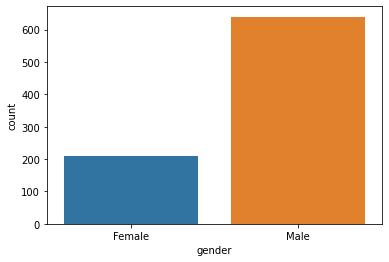

In [8]:
sns_gender = sns.countplot(x="gender", data=train_data)
sns_gender.set_xticklabels(['Female', 'Male']);

Kao što je već napomenuto, godine sam predstavio u intervalima od po 10 godina odnosno podelio sam ih u sledeće klase:

*   0 - 19
*   20 - 29

*   30 - 39
*   40 - 49

*   50 - 59
*   60 - 69

*   70+

Na osnovu sledećeg grafika može se primetiti da je najviše fotografija sa osobama između 20 i 29 godina.













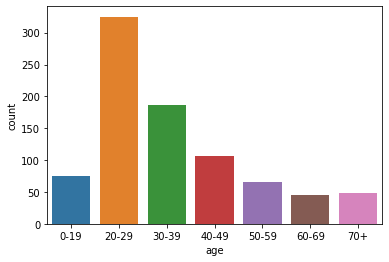

In [9]:
sns_gender = sns.countplot(x="age", data=train_data)
sns_gender.set_xticklabels(['0-19', '20-29','30-39','40-49','50-59','60-69','70+']);

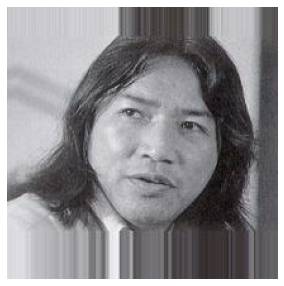

(215, 214, 3)


In [10]:
#Prikaz jedne fotografije iz trening seta
plt.figure(figsize=(5,5))
example_img_url = '/content/wiki_crop/41/10003541_1937-09-27_1971.jpg'
image = imread(example_img_url)
plt.imshow(image), plt.axis('off')
plt.show()
print(image.shape)

Na slici iznad vidimo primer učitavanja jedne slike iz trening seta. Možemo da primetimo da se na slici ne nalazi samo lice, te će za procesiranje podataka biti korišćena funkcija extract_face iz naredne ćelije, gde će se za prosleđenu fotografiju primenom biblioteke mtcnn izvući samo lice sa fotografije, i slika će biti transformisana na prosleđenu veličinu.

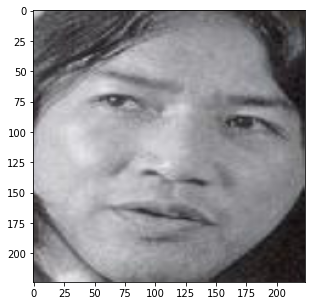

In [11]:
def extract_face(image_file, required_size=(224, 224)):
    # Učitavanje fotografije
    image = imread(image_file)
    if len(image.shape) < 3: image = gray2rgb(image) 
    else: image = image[...,:3]
    # Kreiranje detektora
    detector = MTCNN()
    # Detektovanje lica na ulaznoj fotografiji
    results = detector.detect_faces(image)
    
    # Ekstraktovanje graničnog okvira sa lica
    if not results : return None
    
    else: x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # Ekstraktovanje lica
    face = image[y1:y2, x1:x2]
    # Promena veličine piksela u veličinu modela
    return resize(face, required_size)
    
    

face = extract_face(example_img_url)
plt.figure(figsize=(5,5))
plt.imshow(face)
plt.show()

# Treniranje modela

Nakon učitavanja svih fotografija i analiziranja seta podataka, sledi treniranje modela. Radi boljih rezultata, za svaku od potrebnih detekcija biće kreiran poseban model sem za detekciju emocija pošto podatke o emocijama na skupu fotografija u sklopu zadatka nisam dobio.

Prva opcija jeste kreiranje metode koja omogućava učitavanje i trening i validacionih slika, kao i odgovarajuće prosleđene kolone.

In [12]:
#Učitavanje slika i odgovarajuće kolone koja je prosleđena
def get_images_and_labels(dataset, column_name, image_size):
  data = []
  for index, row in dataset.iterrows():
      extracted_face = extract_face(row.path, image_size)
      #Učitavanje određene detektovane slike lica, i vrednosti kolone za tu sliku
      label = dataset[dataset['path']==row.path][column_name].values[0]
      data.append([extracted_face, label])
      #print(row.image_path)
      #print(label)
  return data

# Detekcija godina

Prvi model koji se kreira biće model za detekciju godina.

Za izradu ovog modela biće korišćen VGG16, konvolucijska neuronska mreža. Konvolucijska neuronska mreža ima jedan input sloj, jedan output sloj, i skrivene slojeve. VGG16 mreža je trenirana na ImageNet bazi podataka. Sastoji se od 16 konvolucijskih slojeva. Kao što je gore napomenuto, ovo je pretrained model, kako bi omogućio bolje rezultate za manje setove podataka.

U narednih nekolija ćelija, učitavaju se slike iz skupa za treniranje i skupa za validaciju, kao kolona prosleđuje se age, podaci se smeštaju u odgovarajući format i normalizuju.

In [13]:
image_size = 128
age_training_data = get_images_and_labels(train_data, 'age', (image_size, image_size))

X_Train = []
Y_Train = []
for img, age in age_training_data:
  if img  is not None : X_Train.append(img) 
  if img  is not None : Y_Train.append(age)
  

X_Train = np.array(X_Train).reshape(-1, image_size, image_size, 3)

X_Train = X_Train / 255
Y_Train = np.array(Y_Train)

X_Train.shape

(661, 128, 128, 3)

In [14]:
image_size = 128
age_testing_data = get_images_and_labels(test_data, 'age', (image_size, image_size))

X_Test = []
Y_Test = []
for img, age in age_testing_data:
  if img  is not None : X_Test.append(img) 
  if img  is not None : Y_Test.append(age)
  

X_Test = np.array(X_Test).reshape(-1, image_size, image_size, 3)

X_Test = X_Test / 255
Y_Test = np.array(Y_Test)

X_Test.shape

(120, 128, 128, 3)

In [15]:
#!pip install tensorflow==2.7.0
from tensorflow.keras.applications.vgg16 import VGG16

# Učitavanje VGG16 modela
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = False

# Prikaz modela bez dodatnih slojeva
base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3004 (InputLayer)     [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [16]:


flatten_layer = layers.Flatten()
dense_layer = layers.Dense(128, activation='relu')
prediction_layer = layers.Dense(7, activation='softmax')

#Dodavanje dodatnih slojeva na gore prikazani model, kao i poslednjeg sloja Dense 9, koji označava da postoji 9 mogućih kategorija za opsege godina.
model_age = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer,
    prediction_layer
])

model_age.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2002 (Flatten)      (None, 8192)              0         
                                                                 
 dense_7007 (Dense)          (None, 128)               1048704   
                                                                 
 dense_7008 (Dense)          (None, 7)                 903       
                                                                 
Total params: 15,764,295
Trainable params: 1,049,607
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
Y_Train = to_categorical(Y_Train, 7)
Y_Test = to_categorical(Y_Test, 7)

Naredna stavka jeste treniranje modela. Kao optimizator korišćen je Adam optimizator, dok je za Learning rate istestirano nekoliko vrednosti, počevši od nekih vrednosti iz sličnih radova koji su već referencirani, a nakon toga i promena hyper parametara radi utvrđivanja što boljih vrednosti.

Takođe je korišćen EarlyStopping u odnosu na val accuracy za stopiranje treniranja u slučaju ponavljanja rezultata kao i ModelCheckpoint za čuvanje najboljeg modela.



In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#Podešavanje i treniranje modela
model_age.compile(
    optimizer=Adam(lr=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

mc = ModelCheckpoint(filepath="age_best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

#Treniranje modela i pamćenje procesa treniranja radi kasnijeg grafičkog prikaza treniranja kroz epohe
history = model_age.fit(X_Train, Y_Train, validation_data=(X_Test, Y_Test), epochs=7, callbacks=[early_stopping,mc])

Epoch 1/7
21/21 [==============================] - ETA: 0s - loss: 1.8167 - accuracy: 0.3359
Epoch 1: val_accuracy improved from -inf to 0.32500, saving model to age_best_model.h5
21/21 [==============================] - 90s 4s/step - loss: 1.8167 - accuracy: 0.3359 - val_loss: 1.9186 - val_accuracy: 0.3250
Epoch 2/7
21/21 [==============================] - ETA: 0s - loss: 1.7393 - accuracy: 0.3525
Epoch 2: val_accuracy did not improve from 0.32500
21/21 [==============================] - 90s 4s/step - loss: 1.7393 - accuracy: 0.3525 - val_loss: 1.7696 - val_accuracy: 0.2250
Epoch 3/7
21/21 [==============================] - ETA: 0s - loss: 1.7010 - accuracy: 0.3676
Epoch 3: val_accuracy did not improve from 0.32500
21/21 [==============================] - 89s 4s/step - loss: 1.7010 - accuracy: 0.3676 - val_loss: 1.7881 - val_accuracy: 0.3250
Epoch 4/7
21/21 [==============================] - ETA: 0s - loss: 1.7350 - accuracy: 0.3238
Epoch 4: val_accuracy did not improve from 0.32500
2

Kao što se može primetiti, rezultati treniranja su dosta slabi, razlog tome je verovatno mali broj fotografija u trening setu kao i veliki broj klasa za detektovanje, očekuje se da rezultati u detekciji pola budu značajno bolji.

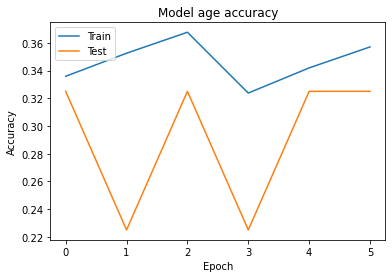

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model age accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Detekcija pola

Naredni model koji se kreira biće model za detekciju pola.

Zaključeno je da za problem detekcije pola dobre rezultate daje model ResNet50, takođe konvolucijska neuronska mreža. ResNet50 mreža je takođe trenirana na ImageNet bazi podataka. Sastoji se od 50 slojeva. Kao što je gore napomenuto, ovo je takođe pretrained model, kako bi omogućio bolje rezultate za manje setove podataka. ResNet prediktuje deltu koja je neophodna da ostvari finalnu predikciju od jednog do drugog sloja. Mapiranje ostvareno u ovom modelu omogućava modelu da zaobiđe CCN weight sloj ukoliko taj sloj nije potreban. To pomaže u izbegavanju problema over fitting-a.

U narednih nekolija ćelija, učitavaju se slike iz skupa za treniranje i skupa za testiranje, kao kolona prosleđuje se gender, podaci se smeštaju u odgovarajući format i normalizuju.

In [20]:
image_size = 128
gender_training_data = get_images_and_labels(train_data, 'gender', (image_size, image_size))

X_Train = []
Y_Train = []
for img, gender in gender_training_data:
  if img  is not None : X_Train.append(img) 
  if img  is not None : Y_Train.append(gender)
  

X_Train = np.array(X_Train).reshape(-1, image_size, image_size, 3)

X_Train = X_Train / 255
Y_Train = np.array(Y_Train)

X_Train.shape

(661, 128, 128, 3)

In [21]:
image_size = 128
gender_testing_data = get_images_and_labels(test_data, 'gender', (image_size, image_size))

X_Test = []
Y_Test = []
for img, gender in gender_testing_data:
  if img  is not None : X_Test.append(img) 
  if img  is not None : Y_Test.append(gender)
  

X_Test = np.array(X_Test).reshape(-1, image_size, image_size, 3)

X_Test = X_Test / 255
Y_Test = np.array(Y_Test)

X_Test.shape

(120, 128, 128, 3)

In [22]:
#Učitavanje ResNet50 modela, prosleđivanje veličine slika, koje su o ovom slučaju 128x128
base_model = tf.keras.applications.ResNet50(include_top=False,
                   weights='imagenet',
                   input_shape=(image_size, image_size, 3),
                   pooling='avg')

for layer in base_model.layers:
        layer.trainable=False

94781440/94765736 [==============================] - 1s 0us/step


In [23]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(256, activation='relu')
dense_layer_2 = layers.Dense(256, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')

#Kreiranje modela dodavanjem dodatnih slojeva, i podešavanje poslednjog sloja na dve vrednosti
model_gender = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model_gender.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4003 (Flatten)      (None, 2048)              0         
                                                                 
 dense_14009 (Dense)         (None, 256)               524544    
                                                                 
 dense_14010 (Dense)         (None, 256)               65792     
                                                                 
 dense_14011 (Dense)         (None, 2)                 514       
                                                                 
Total params: 24,178,562
Trainable params: 590,850
Non-trainable params: 23,587,712
_________________________________________________________________


In [25]:
Y_Train = to_categorical(Y_Train, 2)
Y_Test = to_categorical(Y_Test, 2)

In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#Dodavanje optimizera, early stopping-a i treniranje modela
model_gender.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)


# model check point
mc = ModelCheckpoint(filepath="gender_best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

history = model_gender.fit(X_Train, Y_Train,validation_data=(X_Test, Y_Test), epochs=10, callbacks=[early_stopping,mc])

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.6944
Epoch 1: val_accuracy improved from -inf to 0.77500, saving model to gender_best_model.h5
21/21 [==============================] - 30s 1s/step - loss: 0.6198 - accuracy: 0.6944 - val_loss: 0.5630 - val_accuracy: 0.7750
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.6008 - accuracy: 0.7337
Epoch 2: val_accuracy did not improve from 0.77500
21/21 [==============================] - 25s 1s/step - loss: 0.6008 - accuracy: 0.7337 - val_loss: 0.5409 - val_accuracy: 0.7750
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.7337
Epoch 3: val_accuracy did not improve from 0.77500
21/21 [==============================] - 25s 1s/step - loss: 0.5890 - accuracy: 0.7337 - val_loss: 0.5350 - val_accuracy: 0.7750
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 0.5852 - accuracy: 0.7337
Epoch 4: val_accuracy did not improve from 0.

Kao i što je očekivano, rezultati predikcije pola su dosta bolji u odnosu na predikciju godina.

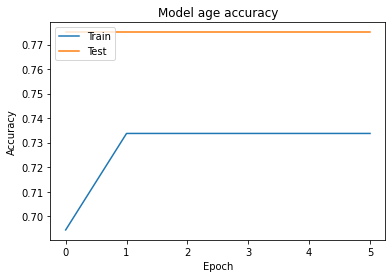

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model age accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Detekcija emocija

Obzirom na to da nisam dobio podatke o emocijama osoba sa fotografija u dataset-u, kod modela za detekciju emocija primenjen javni DeepFace algoritam, takođe je izvršen import cv2 modula.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


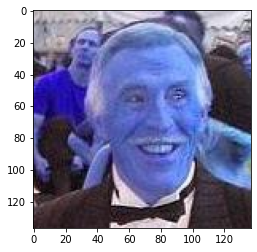

In [38]:
!pip install deepface
import cv2
from deepface import DeepFace
img = cv2.imread('/content/wiki_crop/05/147505_1928-02-22_2007.jpg')
import matplotlib.pyplot as plt
plt.imshow(img) #prikazaće plavu nijasnu 

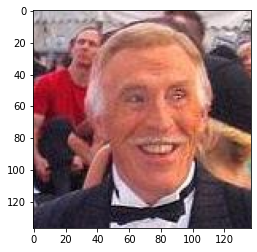

In [39]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #vraćanje slike na prirodan ten

In [40]:
predictions = DeepFace.analyze(img) #analiza slike

Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


In [41]:
type(predictions)

dict

In [42]:
predictions['dominant_emotion']

'happy'

## Testiranje modela

U narednom delu biće istestirani gore kreirani modeli, kako bi se utvrdilo koliko dobro vrše detekciju nad slikama koje do sad modeli nisu videli.

In [34]:
#https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/
# googleimagesdownload --keywords "Euler" --limit 20
%matplotlib inline
#from keras.models import load_model
from tensorflow.keras.models import load_model
#!pip install mtcnn
import mtcnn
# print version
print(mtcnn.__version__)
from mtcnn.mtcnn import MTCNN
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from skimage.io import imread
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
import numpy as np
import matplotlib.pylab as plt
import os

0.1.0


In [35]:
!pip install dlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


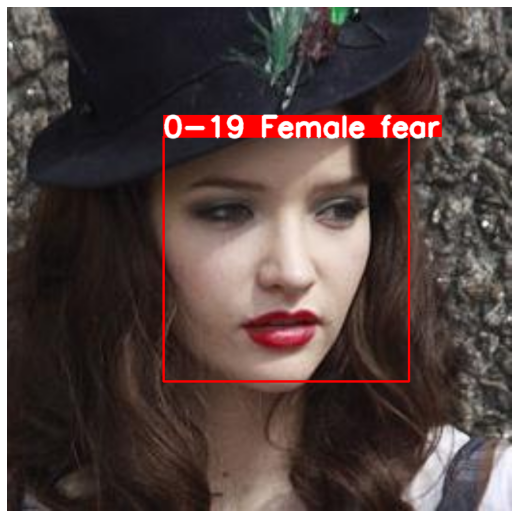

Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


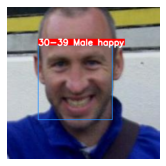

In [58]:
# https://github.com/yu4u/age-gender-estimation
# https://github.com/yu4u/age-gender-estimation/releases/download/v0.5/weights.29-3.76_utk.hdf5
# https://github.com/thegopieffect/computer_vision
# https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/
# https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE
# https://susanqq.github.io/UTKFace/
# https://stackoverflow.com/questions/53859419/dlib-get-frontal-face-detector-gets-faces-in-full-image-but-does-not-get-in-c
from tensorflow import keras
import sys
import numpy as np
from keras.models import Model
from keras import backend as K
import cv2
import dlib
from keras.models import model_from_json
from glob import glob
import matplotlib.pylab as plt

#sys.setrecursionlimit(2 ** 20)
#np.random.seed(2 ** 10)

depth = 16
k = width = 8
margin = 0.4
img_size = 128
#conf_threshold = 0.5

# Funkcija za iscrtavanje graničnih okvira sa oznakom godina/pola
def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1.2, thickness=3):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale, (255, 255, 255), thickness, lineType=cv2.LINE_AA)

# Učitavanje konfiguracije unapred obučenog modela iz JSON datoteke i težine modela iz prethodno obučene datoteke težina

age_model = keras.models.load_model('/content/age_best_model.h5')
gender_model = keras.models.load_model('/content/gender_best_model.h5')
#emotion_model = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/emotion_model.h5')

# Frontalni detektor lica za otkrivanje i izdvajanje lica sa ulaznih fotografija
detector = dlib.get_frontal_face_detector()

plt.figure(figsize=(15,7))
plt.subplots_adjust(0,0,1,1,0.05,0.05)
j = 1

test_list = ['/content/wiki_crop/05/4335905_1985-09-26_2009.jpg','/content/wiki_crop/05/4625305_1977-12-06_2011.jpg']

"""
Za svako lice otkriveno na ulaznoj fotografiji pomoću dlib detektora, 
predvidite starost i pol otkrivenog lica pomoću modela dubokog učenja pokretanjem prosleđivanja lica 
sa licem kao ulaznim podacima i izdvojite predviđenu starost i pol.
"""
for img_file in test_list: #['images/all.png ']: 
    img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
    #img = imread(img_file)
    img_h, img_w, _ = np.shape(img)
    r = 640 / max(img_h, img_w)
    img = cv2.resize(img, (int(img_w * r), int(img_h * r)))

    # Detekcija lica korišćenjem dlib detektora
    detected = detector(img, 0) #0)

    faces = np.empty((len(detected), img_size, img_size, 3))
    
    if len(detected) > 0:
        for i, d in enumerate(detected):
            x1, y1, x2, y2, w, h = d.left(), d.top(), d.right() + 1, d.bottom() + 1, d.width(), d.height()
            xw1 = max(int(x1 - margin * w), 0)
            yw1 = max(int(y1 - margin * h), 0)
            xw2 = min(int(x2 + margin * w), img_w - 1)
            yw2 = min(int(y2 + margin * h), img_h - 1)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            faces[i, :, :, :] = cv2.resize(img[yw1:yw2 + 1, xw1:xw2 + 1, :], (img_size, img_size))

      

        # Predikcija godina i pola detektovanih lica
        ages_list = ['0-19', '20-29','30-39','40-49','50-59','60-69','70+']
        emotions_list = ['Angry', 'Disgusted', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']

        prediction_gender = gender_model.predict(np.asarray(faces))
        prediction_gender_index = np.argmax(prediction_gender)

        if prediction_gender_index:
          cv2.rectangle(img, (x1, y1), (x2, y2), (30, 144, 255), 2)
        else:
          cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
          

        image_size = 128
        faces = np.empty((len(detected), image_size, image_size, 3))
        faces[0, :, :, :] = cv2.resize(img[yw1:yw2 + 1, xw1:xw2 + 1, :], (image_size, image_size))
        prediction_age = age_model.predict(np.asarray(faces))
        prediction_age_index = np.argmax(prediction_age)

        #prediction_emotion = emotion_model.predict(np.asarray(faces))
        #prediction_emotion_index = np.argmax(prediction_emotion)

        predictions = DeepFace.analyze(img)
        

        #results = loaded_model.predict(faces)
        #predicted_genders = results[0]
        #ages = np.arange(0, 101).reshape(101, 1)
        #predicted_ages = results[1].dot(ages).flatten()
        #print(predicted_ages)

        # Iscrtavanje rezultata
        for i, d in enumerate(detected):      
          label = "{} {} {}".format(ages_list[prediction_age_index], "Female" if prediction_gender_index == 0 else "Male", predictions['dominant_emotion'])  
          draw_label(img, (d.left(), d.top()), label)

        plt.subplot(1,2,j), plt.imshow(img), plt.axis('off')
        j += 1

        plt.show()

# Zaključak

Detekcija pola godina i emocija bio je zahtevan ali zanimljiv zadatak.

U radu se mogla videti priprema podataka i treniranje modela upotrebnom transfer learning-a, odnosno modela VGG16 i ResNet50.

Uz promenu dataset-a, odnosno korišćenja mnogo većeg broja slika, velika je verovatnoća da bi dati rezultati bili mnogo bolji.

Nakon učitavanja podataka i treniranja modela, modeli su testirani sa dve nove slike, koje su delimično dobro detektovane.

Najveći izazov u projektu bila je filtracija dataset-a pošto je sadržao dosta škartova i loših fotografija.

## Reference

[1] https://sr.m.wikipedia.org/sr-ec/%D0%94%D1%83%D0%B1%D0%BE%D0%BA%D0%BE_%D1%83%D1%87%D0%B5%D1%9A%D0%B5

[2] Materijali sa vežbi

[3] Korišćeni dataset - https://drive.google.com/file/d/1ztlCf2S68-k4ulB05gWsxGZtbU98jIx_/view?usp=sharing

[4] https://keras.io/

[5] Theckedath, D., & Sedamkar, R. R. (2020). Detecting affect states using VGG16, ResNet50 and SE-ResNet50 networks. SN Computer Science, 1(2), 1-7.